# Projet : Forage de données IFT870

# Data analysis / Analyse des images

Ce notebook contiendra des méthodes liées à l'analyse des images.

### Installation des dépendances

In [91]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
from pymatreader import read_mat
import pandas as pd
import cv2

### Importation de données

In [92]:
nb_images = 3064

class_names = ['meningiome', 'gliome', 'pituitaire']

def load_data(type, nb_images=3064):
    data = {}
    if type == 'mat':
        for i in range(1, nb_images+1):
            dir = "dataset/mat/" + str(i) + ".mat"
            data[i] = read_mat(dir)
        return data
    
    if type == 'png':
        data = [[], [], []]  
        for i in range(len(class_names)):
            dir = "dataset/png/" + str(i+1)
            for path in os.listdir(dir):
                data[i].append(io.imread(dir + "/" + path))
        return data


mat_data = load_data(type='mat')
png_data = load_data(type='png')


### Suppression du canal alpha dans les png

In [93]:
for i in range(len(png_data)):
    for j in range(len(png_data[0])):
        png_data[i][j] = np.delete(png_data[i][j], -1, axis = 2)

### Récupération des valeurs de pixels des ROI

In [94]:
roi_pixel_values = []

for i in range(1, nb_images + 1):
    product_mask_image = mat_data[i]['cjdata']['tumorMask'] * mat_data[i]['cjdata']['image']
    product_mask_image_nonzero = product_mask_image.nonzero()
    roi_pixel_values_img = []
    for j in range(len(product_mask_image_nonzero[0])):
        roi_pixel_values_img.append(product_mask_image[product_mask_image_nonzero[0][j]][product_mask_image_nonzero[1][j]])
    maxpi = np.max(roi_pixel_values_img)
    minpi = np.min(roi_pixel_values_img)
    roi_pixel_values_img_norm = (((roi_pixel_values_img - minpi) / (maxpi - minpi)) * 255).astype(np.uint8)
    roi_pixel_values.append(np.array(roi_pixel_values_img_norm))
    

### Génération des images en noir et blanc

In [95]:
png_data_grey = [ [], [], [] ]
for i in range(len(png_data)):
    for j in range(len(png_data[i])):
        image_grey = cv2.cvtColor(png_data[i][j], cv2.COLOR_BGR2GRAY)
        png_data_grey[i].append(image_grey)

### Analyse des données

#### Affichage des caractéristiques pour chaque image au format png

In [96]:
#https://www.kaggle.com/code/albertozorzetto/98-brain-tumor-classification/notebook
features_img = pd.DataFrame(columns=['Id','Class','Mean_R','Mean_G','Mean_B','Mean','Var_R','Var_G','Var_B','Var','Std_R','Std_G','Std_B','Std','Contrast'])
id_image = 0
for i in range(len(png_data)):
    for j in range(len(png_data[i])):
        mean_tot = np.mean(png_data[i][j])
        var_tot = np.var(png_data[i][j])
        std_tot = np.std(png_data[i][j])
        mean_by_chan = np.mean(png_data[i][j], axis = (0,1))
        var_by_chan = np.var(png_data[i][j], axis = (0,1))
        std_by_chan = np.std(png_data[i][j], axis = (0,1))
        contrast_img = png_data_grey[i][j].std()
        features_img = features_img.append({'Id' : id_image, 'Class' : i, 'Mean_R' : mean_by_chan[0], 'Mean_G' : mean_by_chan[1], 'Mean_B' : mean_by_chan[2], 'Mean' : mean_tot,
                                   'Var_R' : var_by_chan[0], 'Var_G' : var_by_chan[1], 'Var_B' : var_by_chan[2], 'Var' : var_tot,
                                   'Std_R' : std_by_chan[0], 'Std_G' : std_by_chan[1], 'Std_B' : std_by_chan[2], 'Std' : std_tot, 'Contrast' : contrast_img}, ignore_index = True)
        id_image += 1

features_img

,Id,Class,Mean_R,Mean_G,Mean_B,Mean,Var_R,Var_G,Var_B,Var,Std_R,Std_G,Std_B,Std,Contrast
0,0.0,0.0,62.503937,47.530018,113.650990,74.561648,98.959343,2010.637466,583.913550,1699.194803,9.947831,44.840132,24.164303,41.221291,32.169609
1,1.0,0.0,60.984772,49.663212,112.304661,74.317548,129.094792,2546.092121,626.607312,1843.471393,11.361989,50.458816,25.032126,42.935666,35.446762
2,2.0,0.0,60.949844,50.708069,112.040287,74.566067,170.293238,2712.634587,639.523771,1893.791452,13.049645,52.082959,25.288807,43.517714,36.268973
3,3.0,0.0,61.791832,48.241348,109.547665,73.193615,155.090036,2942.800783,649.143793,1940.422603,12.453515,54.247588,25.478300,44.050228,37.449713
4,4.0,0.0,61.222656,48.697399,111.795677,73.905244,125.854385,2534.092404,625.144493,1839.019895,11.218484,50.339770,25.002890,42.883795,35.379750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3059,3059.0,2.0,57.414688,77.870457,122.987656,128.318200,299.253052,2905.205016,548.788346,6850.555593,17.298932,53.899954,23.426232,82.768083,35.615961
3060,3060.0,2.0,61.430229,64.179337,124.215580,126.206286,130.194770,1678.879353,421.983017,6716.530203,11.410292,40.974130,20.542225,81.954440,28.194247
3061,3061.0,2.0,62.264259,62.437584,123.647751,125.837399,140.351683,1634.541697,422.827794,6736.643467,11.847012,40.429466,20.562777,82.077058,27.808481
3062,3062.0,2.0,61.811695,57.945580,121.544212,124.075372,98.619345,1638.288626,442.946776,6894.358662,9.930727,40.475778,21.046301,83.032275,28.540685


<Figure size 432x288 with 0 Axes>

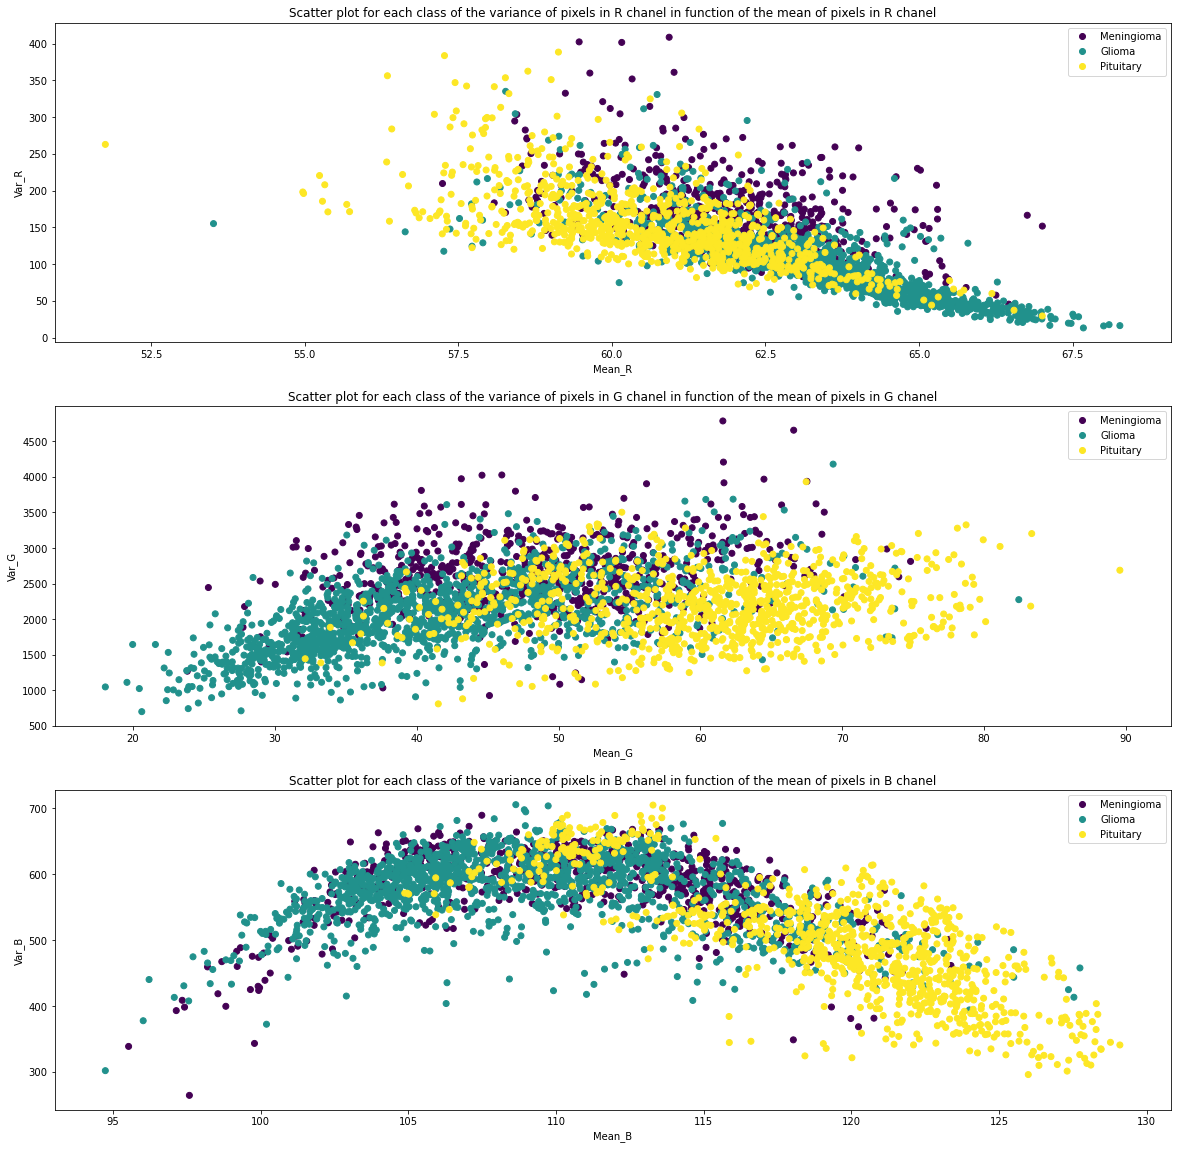

In [97]:
classes = ['Meningioma', 'Glioma', 'Pituitary']

fig = plt.figure()    
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize=(20,20))

scatter1 = axs[0].scatter(features_img['Mean_R'], features_img['Var_R'], c = features_img['Class'])
axs[0].set_xlabel('Mean_R')
axs[0].set_ylabel('Var_R')
axs[0].set_title('Scatter plot for each class of the variance of pixels in R chanel in function of the mean of pixels in R chanel')
axs[0].legend(handles=scatter1.legend_elements()[0], labels=classes)

scatter2 = axs[1].scatter(features_img['Mean_G'], features_img['Var_G'], c = features_img['Class'])
axs[1].set_xlabel('Mean_G')
axs[1].set_ylabel('Var_G')
axs[1].set_title('Scatter plot for each class of the variance of pixels in G chanel in function of the mean of pixels in G chanel')
axs[1].legend(handles=scatter2.legend_elements()[0], labels=classes)

scatter3 = axs[2].scatter(features_img['Mean_B'], features_img['Var_B'], c = features_img['Class'])
axs[2].set_xlabel('Mean_B')
axs[2].set_ylabel('Var_B')
axs[2].set_title('Scatter plot for each class of the variance of pixels in B chanel in function of the mean of pixels in B chanel')
axs[2].legend(handles=scatter3.legend_elements()[0], labels=classes)

plt.savefig("out/scatterplot_images_features.png")

#### Affichage des caractéristiques pour chaque ROI

In [98]:
features_roi = pd.DataFrame(columns=['Id','Class','Mean','Var','Std'])
id_image = 0
class_nb = 0
for i in range(len(roi_pixel_values)):
    if i < 708:
        class_nb = 0
    elif 708 <= i < 1426:
        class_nb = 1
    else:
        class_nb = 2
    mean_tot = np.mean(roi_pixel_values[i])
    var_tot = np.var(roi_pixel_values[i])
    std_tot = np.std(roi_pixel_values[i])
    features_roi = features_roi.append({'Id' : id_image, 'Class' : class_nb, 'Mean' : mean_tot, 'Var' : var_tot, 'Std' : std_tot}, ignore_index = True)
    id_image += 1

features_roi

,Id,Class,Mean,Var,Std
0,0.0,0.0,143.010068,1107.502197,33.279156
1,1.0,0.0,162.160718,1754.024575,41.881077
2,2.0,0.0,180.590905,1283.000560,35.818997
3,3.0,0.0,153.562999,1603.159373,40.039473
4,4.0,0.0,125.271111,3996.271210,63.216068
...,...,...,...,...,...
3059,3059.0,2.0,96.865692,2342.763617,48.402103
3060,3060.0,2.0,87.312101,1138.038366,33.734824
3061,3061.0,2.0,137.763072,3355.050074,57.922794
3062,3062.0,2.0,170.665089,1435.506769,37.888082


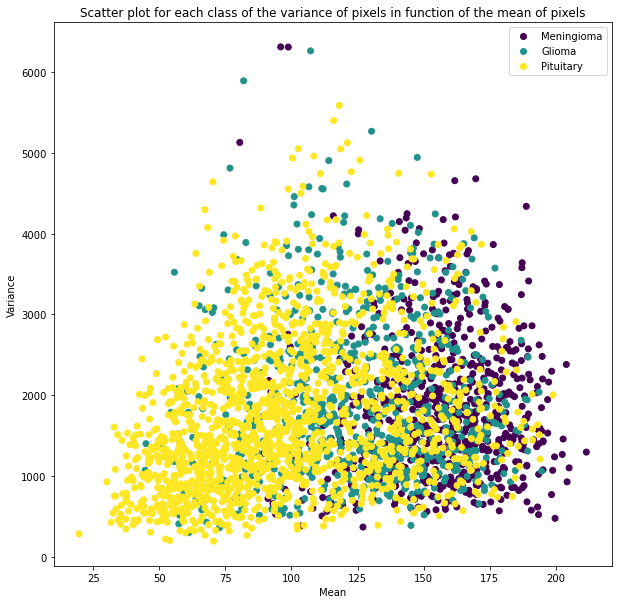

<Figure size 432x288 with 0 Axes>

In [99]:
plt.figure(figsize=(10,10))
scatter = plt.scatter(features_roi['Mean'], features_roi['Var'], c = features_roi['Class'])
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.title('Scatter plot for each class of the variance of pixels in function of the mean of pixels')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()
plt.savefig("out/scatterplot_roi_features.png")

### Distribution de la couleur sur la ROI (pour toutes les données et par classe)

<Figure size 432x288 with 0 Axes>

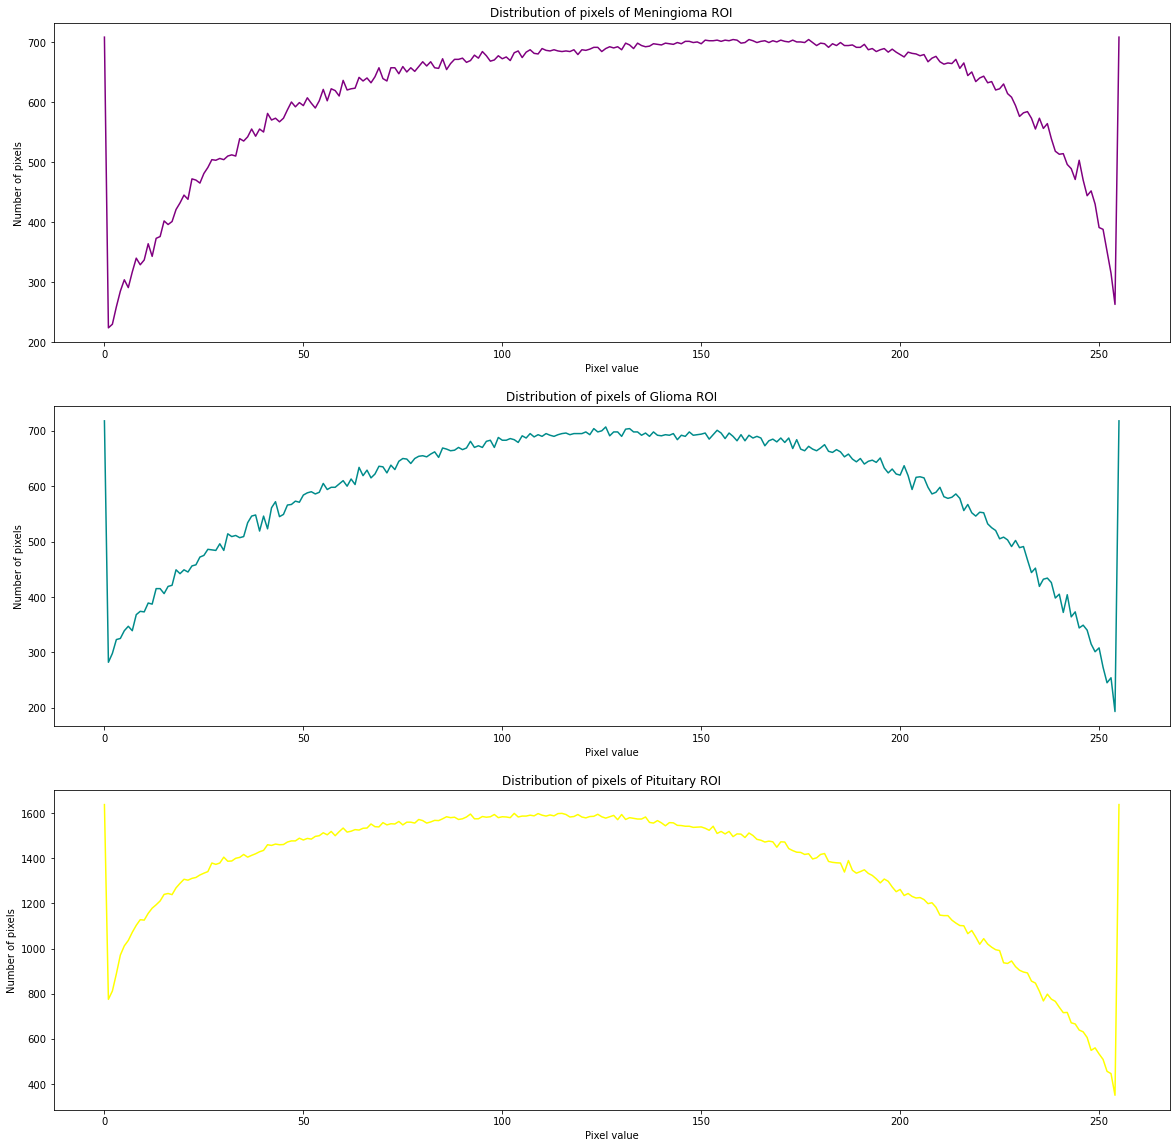

In [102]:
hist_meningioma = np.zeros([256])
hist_glioma = np.zeros([256])
hist_pituitary = np.zeros([256])
for i in range(len(roi_pixel_values)):
    if i < 708:
        hist_meningioma[roi_pixel_values[i]] += 1
    elif 708 <= i < 1426:
        hist_glioma[roi_pixel_values[i]] += 1
    else:
        hist_pituitary[roi_pixel_values[i]] += 1
        
fig = plt.figure()    
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize=(20,20))

axs[0].plot(hist_meningioma, color='purple')
axs[0].set_xlabel('Pixel value')
axs[0].set_ylabel('Number of pixels')
axs[0].set_title('Distribution of pixels of Meningioma ROI')

axs[1].plot(hist_glioma, color='darkcyan')
axs[1].set_xlabel('Pixel value')
axs[1].set_ylabel('Number of pixels')
axs[1].set_title('Distribution of pixels of Glioma ROI')

axs[2].plot(hist_pituitary, color='yellow')
axs[2].set_xlabel('Pixel value')
axs[2].set_ylabel('Number of pixels')
axs[2].set_title('Distribution of pixels of Pituitary ROI')

plt.savefig("out/plot_distribution_roi_pixels.png")